# Simulations 

> Comparison of operation modes on the local network

In [1]:
#| default_exp use

In [1]:
#| export
from fastcore.utils import *
import pandas as pd
from cylinder.hwc_2node import HWC
from cylinder.demand import *
from cylinder.power import *
from cylinder.utils import *
import pandas as pd	
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import defaultdict
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
#| export
#| hide
@patch
def _thermostat(self:HWC):
    "Thermostat state change"
    # Nodal cylinder thermostat
    self.thermostat[0] = 0 if self.temperatures[1] > self.T_set else self.thermostat[0] # Turn off if T > T_set
    self.thermostat[0] = 1 if self.temperatures[1] < self.T_set- self.T_deadband else self.thermostat[0] # Turn on the element
    # Nodal cylinder thermostat
    self.thermostat[1] = 0 if self.temperatures[1] > self.T_set_bu else self.thermostat[1] # Turn off if T > T_set
    self.thermostat[1] = 1 if self.temperatures[1] < self.T_set_bu- self.T_deadband else self.thermostat[1] # Turn on the element
    return self.thermostat

Want to look at some parameters around the cylinder profile and control philosophy to see the impact of these on three aspects:

* The local network lines demand - particularly at peak times where the lines face constraints
* The cost of power to service the demand

## Assumptions

In order to have reasonable comparisons over different operating scenarios we will use the draw profile of a specific 4 bedroom unit from a historical hot water usage dataset.

In [3]:
# | hide
power = load_power(path = Path('../data/'), ripple_control=True)#/home/cjp/cylinder/data/powerprices.csv
strategies = {}
df = {} 

## Base Case

The base installation is a typical 180L hot water cylinder in a 4 bedroom houshold

In [18]:
strategies[0] = {'name': 'Baseline: ~180L 3kW cylinder operating at 60 degrees C under thermotstat control with ripple control power supply',
                'operation': 'continuous',
                'bedrooms': 4,
                'element' :3,
                'Tset_H' : 60.0,
                'Tset_L' : 60.0,
                'radius' : 0.22,
                'height' : 1.1,
                'ripple' : True,
                'mixed' : False}

In [27]:
def run_simulation(strategy, power, time_period):
    env = HWC(T_set=strategy['Tset_H'], 
            radius=strategy['radius'],
            height=strategy['height'],
            element=strategy['bedrooms'],
            mixed=strategy['mixed'],
            T_cold=15,
            T_inlet=15,
            U=.8,
            K=.05,
            noisey=False)
    temp = []
    flow = load_demand(path = Path('../data/drawprofiles'),
                    bed=strategy['bedrooms'],
                    unit=0).loc[:,'flow']
    for row in power.loc[time_period].itertuples(): # go through a set time period
        action = 0
        element = 0 # heating power
        # print(strategy)
        # adjust for temperature
        env._thermostat()
        # establish if there is power going to the element based on the thermostat state and the strategy in relation to ripple control
        if env.thermostat[0] == 1: # if the thermostat high temperature sensor is on then need to look to the control strategy
            if strategy['operation'] == 'off_peak': # if the strategy is to use the thermostat high temperature sensor then the element is on
                action = ~row.peak
                element = 2 if action == 1 else 0
            elif strategy['operation'] == 'continuous': # if the strategy is to use the thermostat high temperature sensor then the element is on
                action = 1
                element = 2 if action == 1 else 0

            elif strategy['operation'] == 'price': # if the strategy is to use the thermostat high temperature sensor then the element is on
                # action = 1 if row.cost < 0.1 else 0
                action = 1 if row.costrank_4h < 0.25 else 0
                element = 2 if action == 1 else 0


        if env.thermostat[1] == 1: # if the thermostat base temperature sensor is on then the element is on
            action = 1
            element = 1


        if (strategy['ripple']) & (row.ripple_control): # if ripple control is on then override the thermostat state
            action = 0
            element = 3
        # print(action, flow.loc[row.Index]*60)
        env._update_model(action = action , flow = flow.loc[row.Index]*60)
        temp.append([strategy,
                    action,
                    row.ripple_control * strategy['ripple'] ,
                    *env.thermostat.copy(),
                    *env.temperatures.copy(),
                    env.z,
                    env.volume,
                    element])
    tmp = pd.DataFrame(temp, 
                      columns=['strategy',
                                'action',
                            'ripple_control_demand',
                            'thermostat_high',
                            'thermostat_base',
                            'T0',
                            'T1',
                            'z',
                            'volume',
                            'element_power'])
    return pd.concat([power.loc[time_period].reset_index(),
            flow.loc[time_period].reset_index(drop=True),
            tmp.assign(energy = lambda df: df.volume.mean()*4.2*((df.T0*df.z + df.T1*(1-df.z))-55))],axis=1).set_index('timestamp')

In [19]:
df[0] = run_simulation(strategies[0], power, time_period='2020-06')

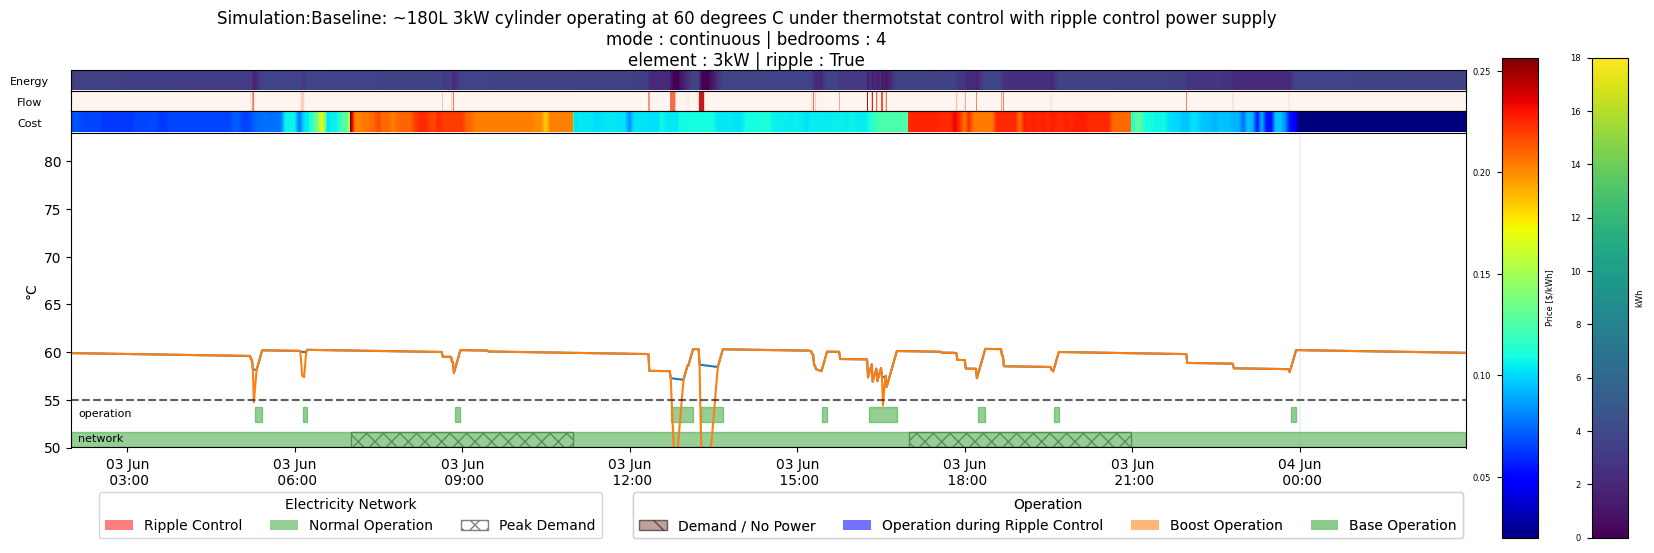

In [20]:
plot_sim(strategies[0], df[0].iloc[3000:4500],verbose=True)

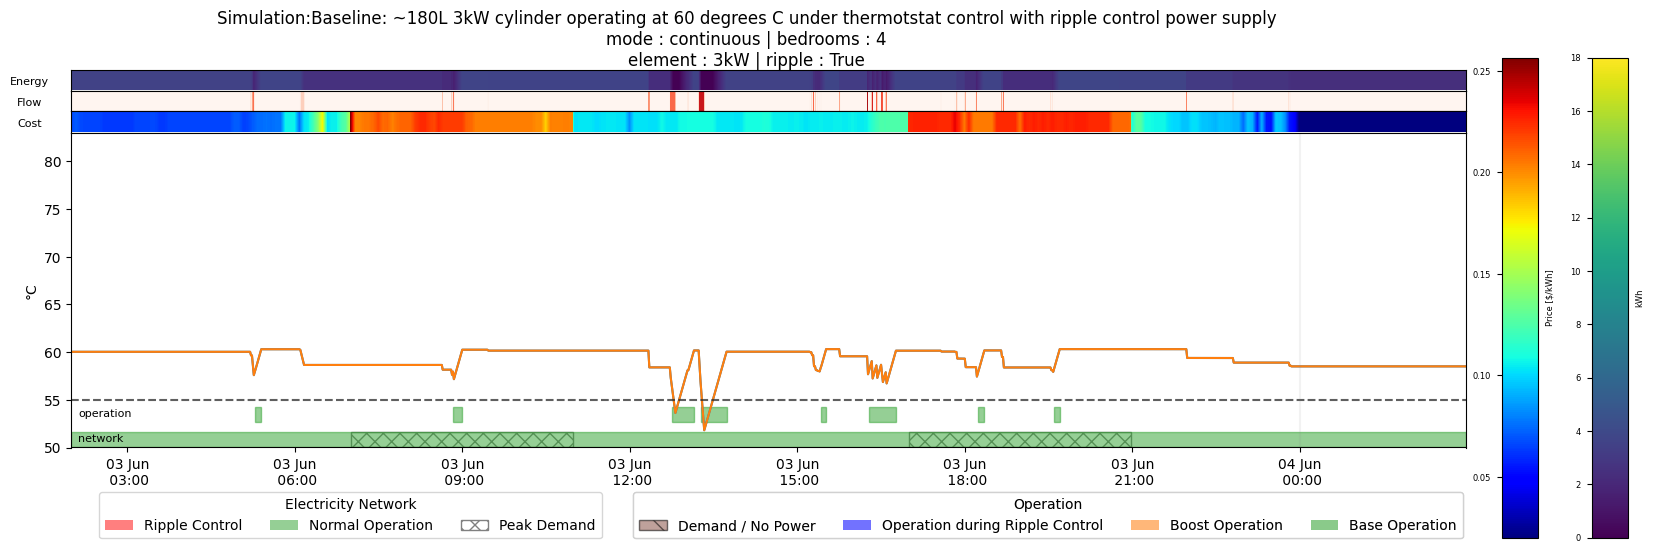

In [17]:
# |filter_stream FutureWarning
plot_sim(strategies[0], df[0].iloc[3000:4500])

## Base Case without Ripple Control

The base installation is a typical 180L hot water cylinder in a 4 bedroom houshold however the cylinder is not interupted by ripple control


In [9]:
strategies[1] = {'name':'Baseline case: current operation with no ripple control',
            'operation': 'off_peak',
            'bedrooms': 4,
            'element' :3,
            'Tset_H' : 60.,
            'Tset_L' : 60.,
            'radius' : 0.22,
            'height' : 1.1,
            'ripple' : False,
            'mixed' : False,
            }

In [10]:
#| hide
df[1] = run_simulation(strategies[1], power, time_period='2020-06')


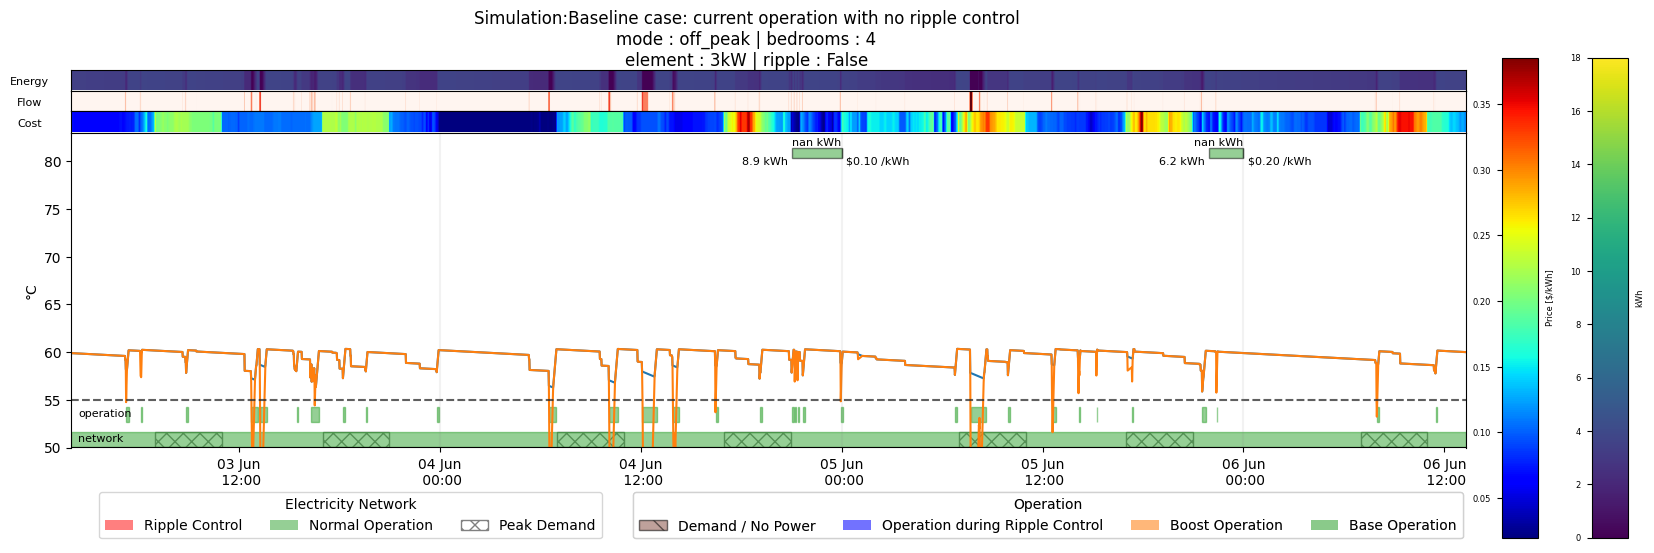

In [11]:
# |filter_stream FutureWarning
plot_sim(strategies[1], df[1].iloc[3000:8000], verbose=True)

## Thermal Boosting on Base Case with no Ripple Control

Apply Thermal Boosting Control on the base installation with the cylinder withou ripple control

In [21]:
strategies[2] = {'name': 'Split Control: remote operation on price signal with ripple control',
            'operation': 'price',
            'bedrooms': 4,
            'element' :3,
            'Tset_H' : 75.,
            'Tset_L' : 60.,
            'radius' : 0.22,
            'height' : 1.1,
            'ripple' : False,
            'mixed' : True,
            }

In [28]:
#| hide
df[2] = run_simulation(strategies[2], power, time_period='2020-06')


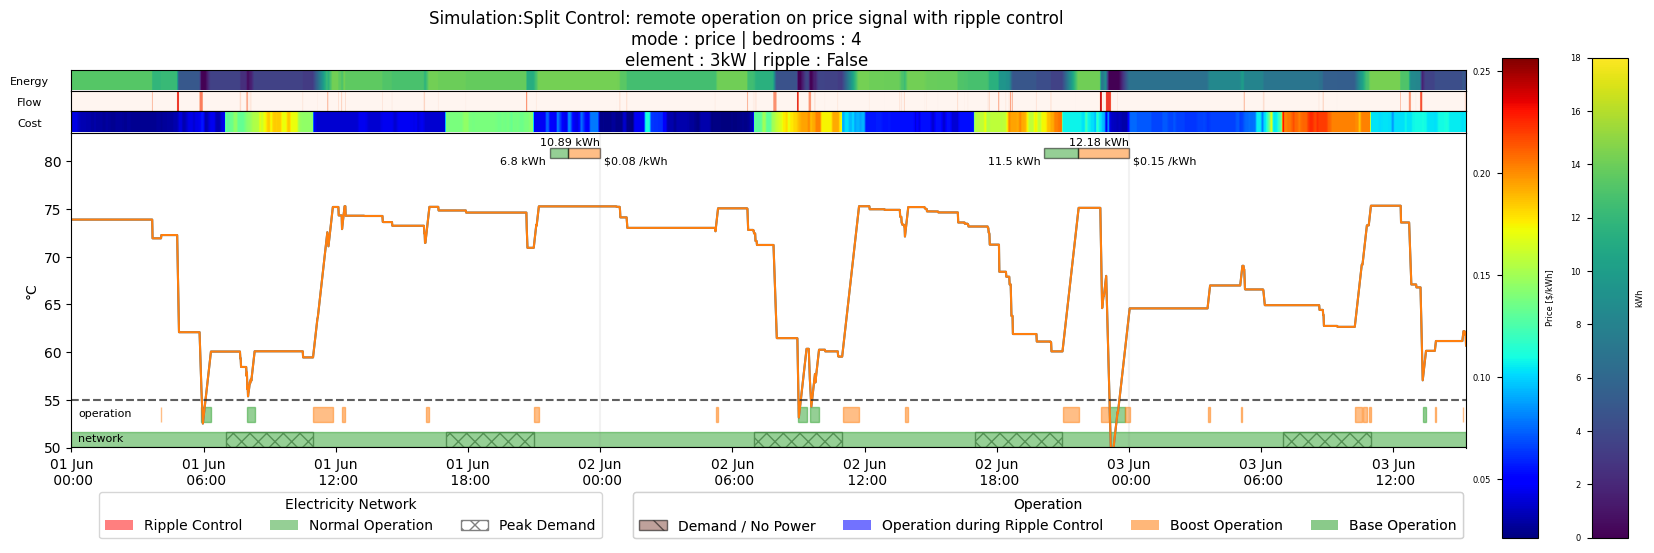

In [29]:
# |filter_stream FutureWarning , .iteritems()
plot_sim(strategies[2], df[2].iloc[:3800], verbose=True)

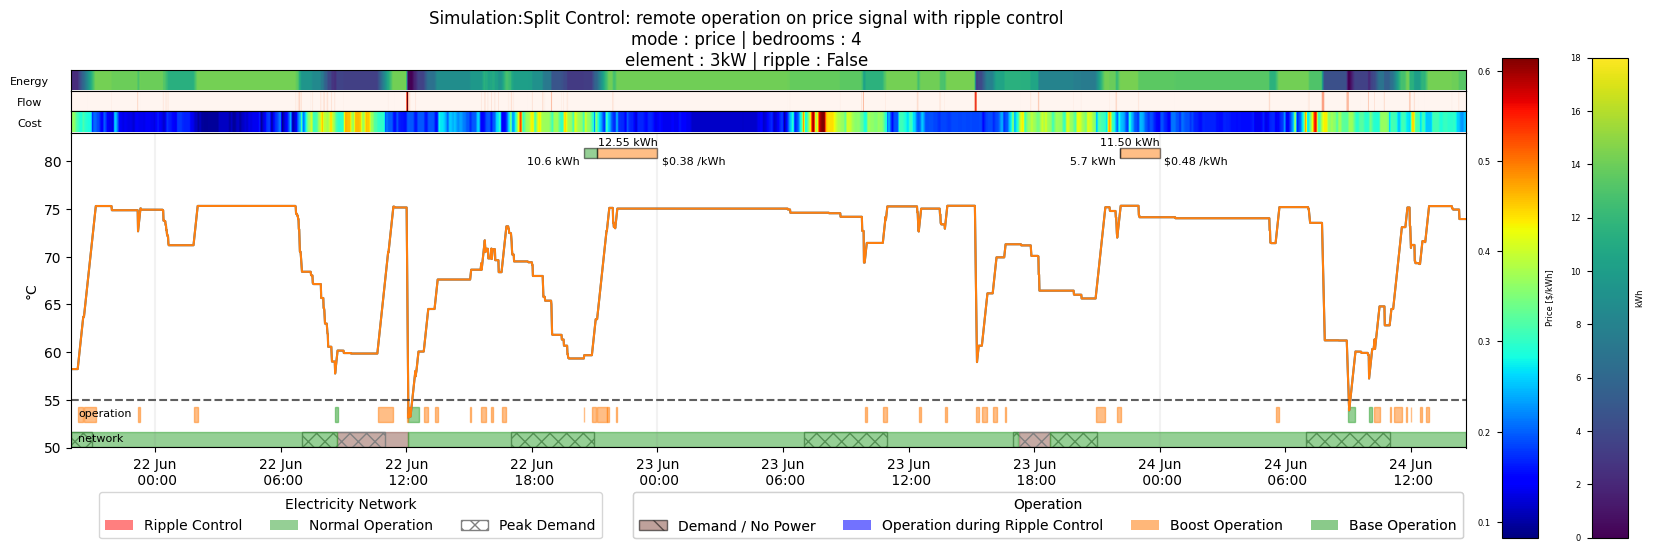

In [31]:
# |filter_stream FutureWarning , .iteritems()
plot_sim(strategies[2], df[2].iloc[30000:34000], verbose=True)

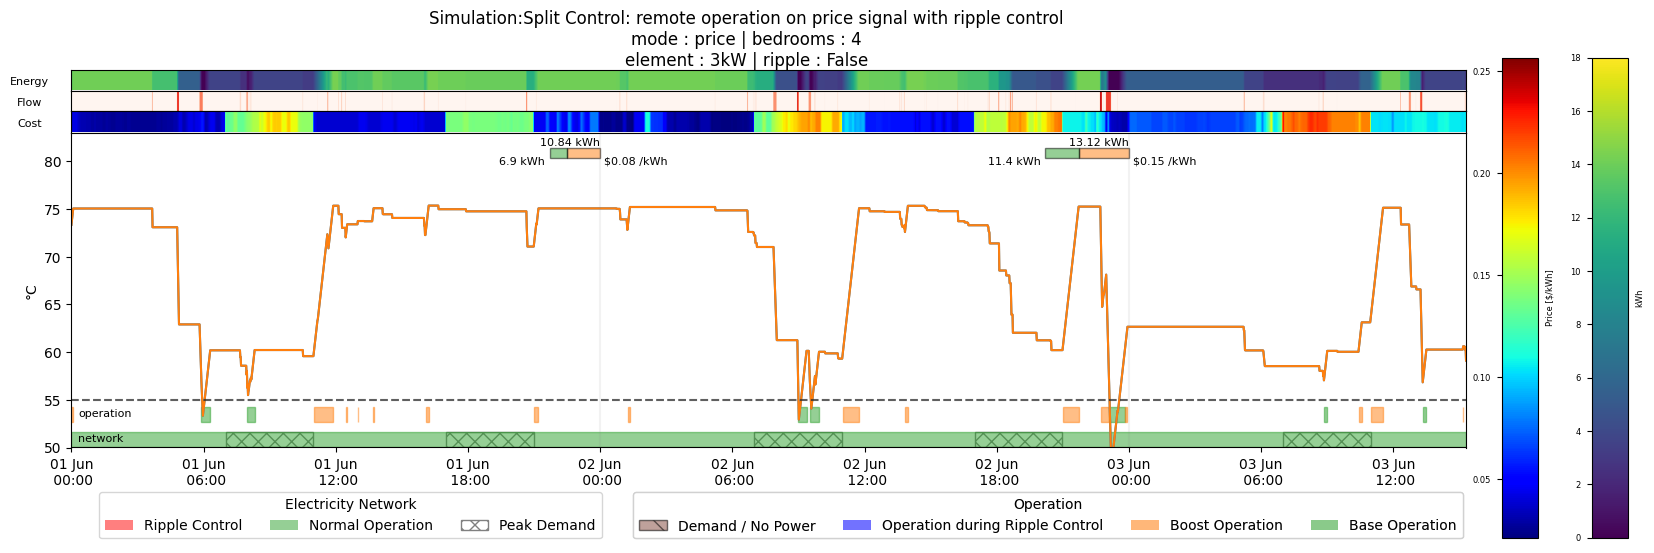

In [12]:
# |filter_stream FutureWarning , .iteritems()
plot_sim(strategies[2], df[2].iloc[:3800], verbose=True)

## Thermal Boosting with larger cylinder and element

Apply Thermal Boosting Control on a ~280 L cylinder with a slightly larger element.

In [24]:
strategies[3] = {'name': 'Split Control: remote operation on price signal with no ripple control',
            'operation': 'price',
            'bedrooms': 4,
            'element' :3.6,
            'Tset_H' : 75.,
            'Tset_L' : 60.,
            'radius' : 0.25,
            'height' : 1.4,
            'ripple' : False,
            'mixed' : True,}

In [25]:
#| hide
df[3] = run_simulation(strategies[3], power, time_period='2020-06')


In [8]:
#| export
def plot_sim(strategy, df, verbose=True):
    boost_color = 'tab:orange'
    network_color = 'tab:green'
    network_rc = 'tab:brown'
    network_color = 'tab:green'
    fig, ax = plt.subplots(nrows=4,figsize=(18,6), sharey="row", gridspec_kw=dict(height_ratios=[.2,.2,.2,3], hspace=0))

    im2 = ax[0].imshow(df.energy.values[np.newaxis,:], cmap="viridis", aspect="auto", vmin=0, vmax=18)
    ax[0].set_ylabel('Energy', rotation=0, fontsize=8)

    ax[1].imshow(df.flow.values[np.newaxis,:], cmap="Reds", aspect="auto")
    ax[1].set_ylabel('Flow', rotation=0, fontsize=8)
    
    im = ax[2].imshow(df.cost.values[np.newaxis,:], cmap="jet", aspect="auto")
    ax[2].set_ylabel('Cost', rotation=0, fontsize=8)
    
    for i in range(3):
        ax[i].yaxis.set_label_coords(-0.03,.2)
        ax[i].set_yticks([])
        ax[i].set_xticks([])

    # add title
    title = f'Simulation:'+ strategy['name'] + '\n' +\
            'mode : ' + strategy['operation'] + ' | ' +\
            'bedrooms : ' + str(strategy['bedrooms']) + '\n' +\
            'element : ' + str(strategy['element']) + 'kW | ' +\
            'ripple : ' + str(strategy['ripple'])
    i=3
    for j in range(2):
        ax[i].plot(df[f'T{j}'], label=f'T{j}')
    ax[i].set_ylim(50,83)

    ax[i].set_ylabel('°C', rotation=90)
    ax[i].margins(x=0, y=0)
    ax[i].axhline(y=55, color='grey', linestyle='--', alpha = .5)
    
    for k in series_timestamps((df.thermostat_base == 1)&(df.ripple_control)&(strategy['ripple'])): ax[i].axvspan(k[0], k[1], 0.08, .13, color=network_rc, alpha=0.5, hatch ='\\', ec='black') # wants power but ripple control is on
    for k in series_timestamps((df.element_power == 3)&(df.ripple_control)&(~strategy['ripple'])): ax[i].axvspan(k[0], k[1], 0.08, .13, color='blue', alpha=0.5) # wants power but ripple control is on
    
    # show the actual power usage
    for k in series_timestamps((df.element_power == 1)): ax[i].axvspan(k[0], k[1], 0.08, .13, color=network_color, alpha=0.5)
    for k in series_timestamps((df.element_power == 2)): ax[i].axvspan(k[0], k[1],  0.08, .13,color=boost_color, alpha=0.5)
    
    
    operation_legend = [Patch(facecolor=network_rc, hatch ='\\', ec='black', alpha=0.5 , label='Demand / No Power'),
                      Patch(facecolor='blue', alpha=0.5 ,  label='Operation during Ripple Control'),
                      Patch(facecolor=boost_color, alpha=0.5 ,  label='Boost Operation'),
                      Patch(facecolor=network_color, alpha=0.5 ,   label='Base Operation')]

    ax[i].axhline(y=55, color='k', linestyle='--', alpha = .5)
    # show the network status

    for k in series_timestamps((df.ripple_control)): ax[i].axvspan(k[0], k[1], 0, .05, color=network_rc, alpha=0.5) # wants power but ripple control is on
    for k in series_timestamps((df.peak)): ax[i].axvspan(k[0], k[1], 0, .05, fc='none',hatch ='xx', ec='grey') # wants power but ripple control is on
    for k in series_timestamps((~df.ripple_control)): ax[i].axvspan(k[0], k[1], 0, .05, color=network_color, alpha=0.5) # wants power but ripple control is on
    network_legend = [Patch(facecolor='red', alpha=0.5 , label='Ripple Control'),
                      Patch(facecolor=network_color, alpha=0.5 ,  label='Normal Operation'),
                      Patch(facecolor='none', hatch='xx', ec='grey', label='Peak Demand')]


    legend1 = plt.legend(handles = network_legend,loc='upper center',title="Electricity Network", bbox_to_anchor=(0.2, -0.12), fancybox=True, shadow=False, ncol=3)
    legend2 = plt.legend(handles = operation_legend,loc='upper center',title="Operation", bbox_to_anchor=(0.7,-.12), fancybox=True, shadow=False, ncol=4)
    ax[i].add_artist(legend1)
    ax[i].add_artist(legend2)

    # add a colorbar for the price to the right of the plot
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Price [$/kWh]', rotation=90, labelpad=5, fontsize=6)
    cbar_ax.yaxis.set_label_position('right')
    cbar_ax.yaxis.set_ticks_position('left')
    cbar_ax.yaxis.set_tick_params(pad=5)
    # cbar_ax.set_ylim(0, 0.2)
    cbar1_ax = fig.add_axes([0.97, 0.1, 0.02, 0.8])
    fig.colorbar(im2, cax=cbar1_ax)
    cbar1_ax.set_ylabel('kWh', rotation=90, labelpad=5, fontsize=6)
    cbar1_ax.yaxis.set_label_position('right')
    cbar1_ax.yaxis.set_ticks_position('left')
    cbar1_ax.yaxis.set_tick_params(pad=5)
    
    date_form = DateFormatter('%d %b\n %H:%M')
    ax[-1].xaxis.set_major_formatter(date_form)
    cbar_ax.yaxis.set_tick_params(labelsize=6)
    cbar1_ax.yaxis.set_tick_params(labelsize=6)
    ax[i].annotate('network', xy=(0, 0), xycoords='axes fraction',  xytext=(5, 10), textcoords='offset points', ha="left", va="top", fontsize=8)
    ax[i].annotate('operation', xy=(0, 0), xycoords='axes fraction',  xytext=(5, 28), textcoords='offset points', ha="left", va="top", fontsize=8)
    # add some whitespace to the bottom of the plot
    # add a line at the end of each day
    if verbose:
        complete_days = df.groupby('date').size().reset_index()
        complete_days = pd.to_datetime(complete_days[complete_days[0]==1440].date.tolist())
        # print(complete_days)
        for n,k in enumerate(complete_days): 
            e1 = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==1)].element_power.count()
            e2 = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].element_power.count()
            e1p = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==1)&(df.peak)].element_power.count()
            e2p = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)&(df.peak)].element_power.count()
            e3 = 0
            en_max = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].energy.max()
            en_min = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].energy.min()
            en_range = abs(en_max-en_min)

            # print(en_range,e2,e3)
            c = (df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)|(df.element_power==1)].element_power * \
                df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)|(df.element_power==1)].cost).sum() /60*strategy['element']
            kwh = (e1+e2)/60*strategy['element']
            avecost = c/kwh
            base = k + pd.Timedelta(f'1d')
            ax[i].axvspan(base-pd.Timedelta(f'{e2}m'), base, 0.92, .95, color=boost_color, alpha=0.5, ec='black')
            ax[i].axvspan(base-pd.Timedelta(f'{e2}m') - pd.Timedelta(f'{e1}m'), base-pd.Timedelta(f'{e2}m'), 0.92, .95, color=network_color, alpha=0.5, ec='black')
            ax[i].annotate(f'{kwh:.1f} kWh', xy=(base- pd.Timedelta(f'{e1+e2+e3}m'), 80), xycoords='data',  xytext=(-3, 0), textcoords='offset points', ha="right", va="center", fontsize=8)
            ax[i].annotate(f'${avecost:.2f} /kWh', xy=(base, 80), xycoords='data',  xytext=(3, 0), textcoords='offset points', ha="left", va="center", fontsize=8)
            
            ax[i].annotate(f'{en_range:.2f} kWh', xy=(base, 82), xycoords='data',  xytext=(0, 0), textcoords='offset points', ha="right", va="center", fontsize=8)

        for k in df.index.floor('D').unique()[1:]: ax[i].axvline(k, color='grey', alpha = .1)


    fig.subplots_adjust(bottom=0.25)
    fig.suptitle(title)
    return 

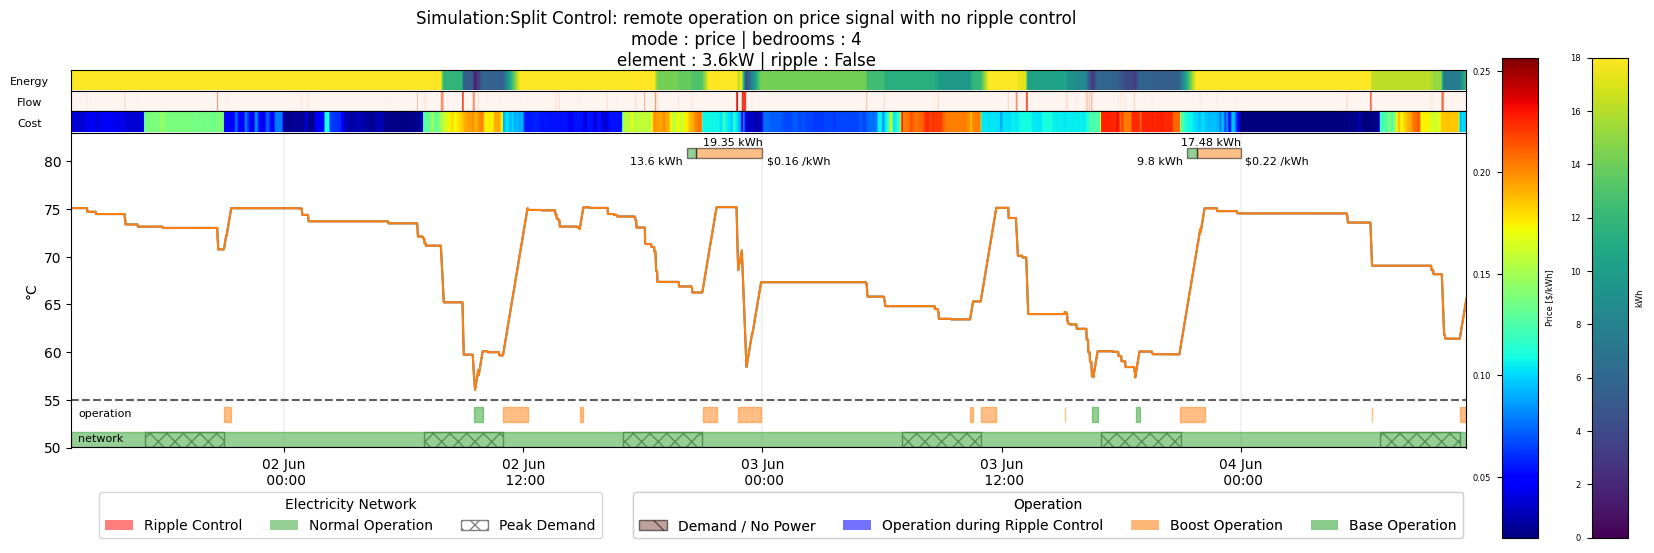

In [26]:
# |filter_stream FutureWarning
plot_sim(strategies[3], df[3].iloc[800:5000], verbose=True)

In [10]:
# add a column of the daily sum of price
df[3].assign(kwh_boost = lambda df: df[df.element_power ==2].groupby('date').element_power.transform('count'),
             kwh_base = lambda df: df[df.element_power ==1].groupby('date').element_power.transform('count'),
)

KeyError: 3

In [11]:
df[3]['2020-06-17'].element_power.value_counts()

KeyError: 3

In [62]:
# get grouped aggregate data
df[2].assign(prop = lambda df: df.energy/df.energy.max()).groupby(['date']).agg({'energy':{'min','max'},'prop':{'min','max'}}).plot()
# df[2].groupby(['date']).agg({'energy':{'min','max'}}),

,price,ripple_control,price_kw,date,week,season,hour,day,peak,tou,...,strategy,action,ripple_control_demand,thermostat_high,thermostat_base,T0,T1,z,volume,energy
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,12.310,False,0.012310,2020-06-01,23,Winter,0,0,0,0.02,...,2,1,0,1,0,72.529481,71.633686,0.7,0.167258,12.125417
2020-06-01 00:01:00,14.216,False,0.014216,2020-06-01,23,Winter,0,0,0,0.02,...,2,1,0,1,0,72.601704,72.601704,0.7,0.167258,12.364937
2020-06-01 00:02:00,16.122,False,0.016122,2020-06-01,23,Winter,0,0,0,0.02,...,2,1,0,1,0,72.942652,72.942652,0.7,0.167258,12.604448
2020-06-01 00:03:00,18.028,False,0.018028,2020-06-01,23,Winter,0,0,0,0.02,...,2,1,0,1,0,73.283588,73.283588,0.7,0.167258,12.843951
2020-06-01 00:04:00,19.934,False,0.019934,2020-06-01,23,Winter,0,0,0,0.02,...,2,1,0,1,0,73.624513,73.624513,0.7,0.167258,13.083445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 23:55:00,97.700,False,0.097700,2020-06-30,27,Winter,23,1,0,0.02,...,2,0,0,0,0,75.084284,75.084284,0.7,0.167258,14.108913
2020-06-30 23:56:00,89.938,False,0.089938,2020-06-30,27,Winter,23,1,0,0.02,...,2,0,0,0,0,75.082195,75.082195,0.7,0.167258,14.107446
2020-06-30 23:57:00,82.176,False,0.082176,2020-06-30,27,Winter,23,1,0,0.02,...,2,0,0,0,0,75.080107,75.080107,0.7,0.167258,14.105979


# Compare Simultions 

In [45]:
# how many days in the dataset  
df.index.floor('D').unique().shape

AttributeError: 'dict' object has no attribute 'index'

In [52]:
#| hide
data = []
days = df[0].index.floor('D').unique().shape
for n, sim in enumerate(df):
    t_mean = (0.7*df[n].T0.mean()+ 0.3*df[n].T1.mean())
    peak_demand = (df[n].peak*strategies[n]["element"]*df[n].action).sum()/len(df[n])
    # print(f'demand at peak : {100*peak_demand:.2f}%')
    local_kwh = df[n].loc[df[n].element_power==1].element_power.count()*strategies[n]["element"]/60
    remote_kwh = df[n].loc[df[n].element_power==2].element_power.count()*strategies[n]["element"]/60
    total_kwh = local_kwh+remote_kwh
    # print(f'Local kWh : {local_kwh:.2f}',end=' ')
    # print(f'Remote kWh : {remote_kwh:.2f}')
    local_cost = (df[n].cost*strategies[n]["element"]/60*df[n].action*df[n].thermostat_base).sum()
    remote_cost = (df[n].cost*strategies[n]["element"]/60*df[n].action*df[n].thermostat_high*(df[n].thermostat_base!=1)).sum()
    # print(f'Local Cost : {local_cost/local_kwh:.2f}',end=' ')
    # print(f'Remote Cost : {remote_cost/remote_kwh:.2f}')

    loss_of_service = 100*(df[n].T0<55).sum()/len(df[n])
    days = (df[0].iloc[-1].name-df[0].iloc[0].name).days
    # print(f'Days : {days:.2f}')    
    # print(f'Loss of Service : {100*loss_of_service:.2f}%')    
    data.append([*strategies[n].values(),
                 df[n].iloc[0].name,
                 df[n].iloc[-1].name,
                 df[n].volume.mean()*1000,
                 peak_demand,
                 local_kwh,
                 remote_kwh,
                 local_kwh+remote_kwh,
                 local_cost,
                 remote_cost,
                 local_cost+remote_cost,
                 t_mean,
                 loss_of_service])
summary = pd.DataFrame(data,columns=list(strategies[0].keys())+['start_time', 'end_time', 'volume','peak_demand', 'local_kwh', 'remote_kwh', 'total_kwh', 'local_cost', 'remote_cost', 'total_cost', 't_mean', 'loss_of_service'])
summary['peak_reduction'] = 100*(summary.peak_demand-summary.loc[0,'peak_demand'])/summary.loc[0,'peak_demand']
summary['cost_reduction'] = 100*(summary.total_cost-summary.loc[0,'total_cost'])/summary.loc[0,'total_cost']
summary['daily_kWh'] = summary.total_kwh/days



In [53]:
summary.T

,0,1,2
name,Baseline: ~180L 3kW cylinder operating at 60 d...,Baseline case: current operation with no rippl...,Split Control: remote operation on price signa...
operation,continuous,off_peak,price
bedrooms,4,4,4
element,3,3,3
Tset_H,60.0,60.0,75.0
Tset_L,60.0,60.0,60.0
radius,0.22,0.22,0.22
height,1.1,1.1,1.1
ripple,True,False,False
start_time,2020-06-01 00:00:00,2020-06-01 00:00:00,2020-06-01 00:00:00


In [47]:
#| hide
import nbdev; nbdev.nbdev_export()